<a href="https://colab.research.google.com/github/AbhiRajBajpai/Life-Expectancy-Predictions/blob/main/TCS_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
try:
    history_df = pd.read_csv('TCS_stock_history.csv')
    info_df = pd.read_csv('TCS_stock_info.csv', header=None, index_col=0)
    action_df = pd.read_csv('TCS_stock_action.csv')
except FileNotFoundError as e:
    print("⚠️ Make sure you have uploaded the following files to your Colab session:")
    print("TCS_stock_history.csv, TCS_stock_info.csv, TCS_stock_action.csv")
    print(e)

In [3]:
# Display basic information about the historical data
print("--- TCS Stock History ---")
print(history_df.head())
print("\n--- Data Info ---")
history_df.info()

--- TCS Stock History ---
         Date       Open       High        Low      Close  Volume  Dividends  \
0  2002-08-12  28.794172  29.742206  28.794172  29.519140  212976        0.0   
1  2002-08-13  29.556316  30.030333  28.905705  29.119476  153576        0.0   
2  2002-08-14  29.184536  29.184536  26.563503  27.111877  822776        0.0   
3  2002-08-15  27.111877  27.111877  27.111877  27.111877       0        0.0   
4  2002-08-16  26.972458  28.255089  26.582090  27.046812  811856        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4463 non-null   object 
 1   Open          4463 non-null   float64
 2   High          4463 non-null   float64
 3   Low           4463 non-null   float64
 4

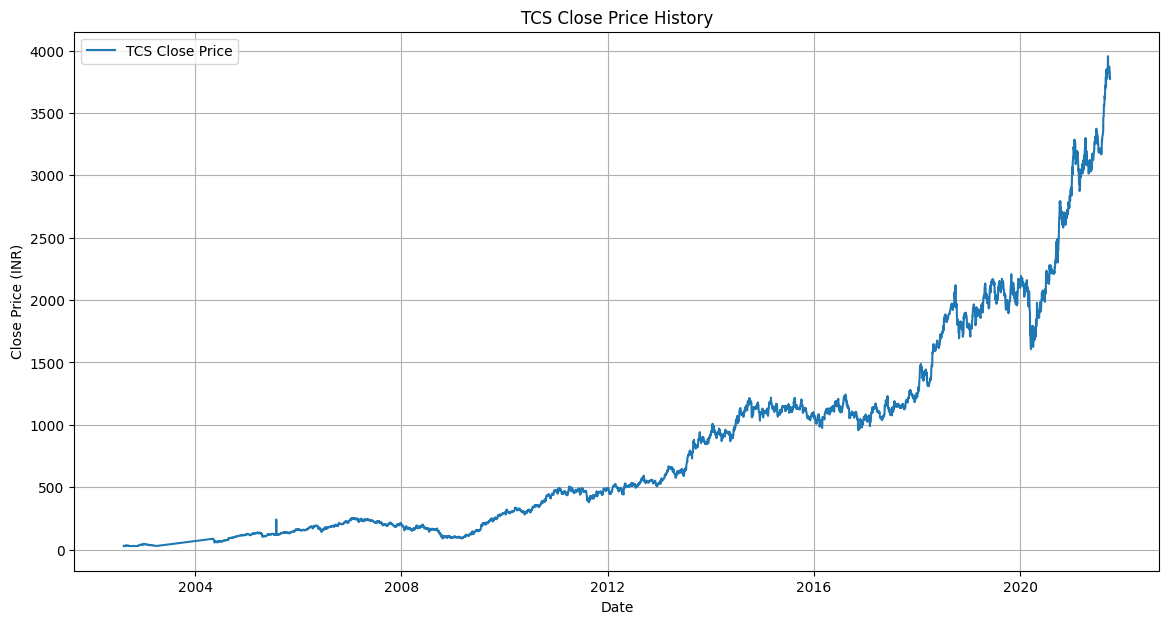

In [4]:
# Convert the 'Date' column to datetime objects
history_df['Date'] = pd.to_datetime(history_df['Date'])

# Plot the closing price history
plt.figure(figsize=(14, 7))
plt.plot(history_df['Date'], history_df['Close'], label='TCS Close Price')
plt.title('TCS Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close' column
data = history_df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on (80% of the data)
training_data_len = int(np.ceil(len(dataset) * .8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (4463, 1)


In [6]:
# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (3511, 60, 1)
y_train shape: (3511,)


In [7]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3511/3511 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - loss: 3.1253e-04


In [9]:
# Create a new array containing scaled values for the test set
test_data = scaled_data[training_data_len - 60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"x_test shape: {x_test.shape}")

x_test shape: (892, 60, 1)


In [10]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


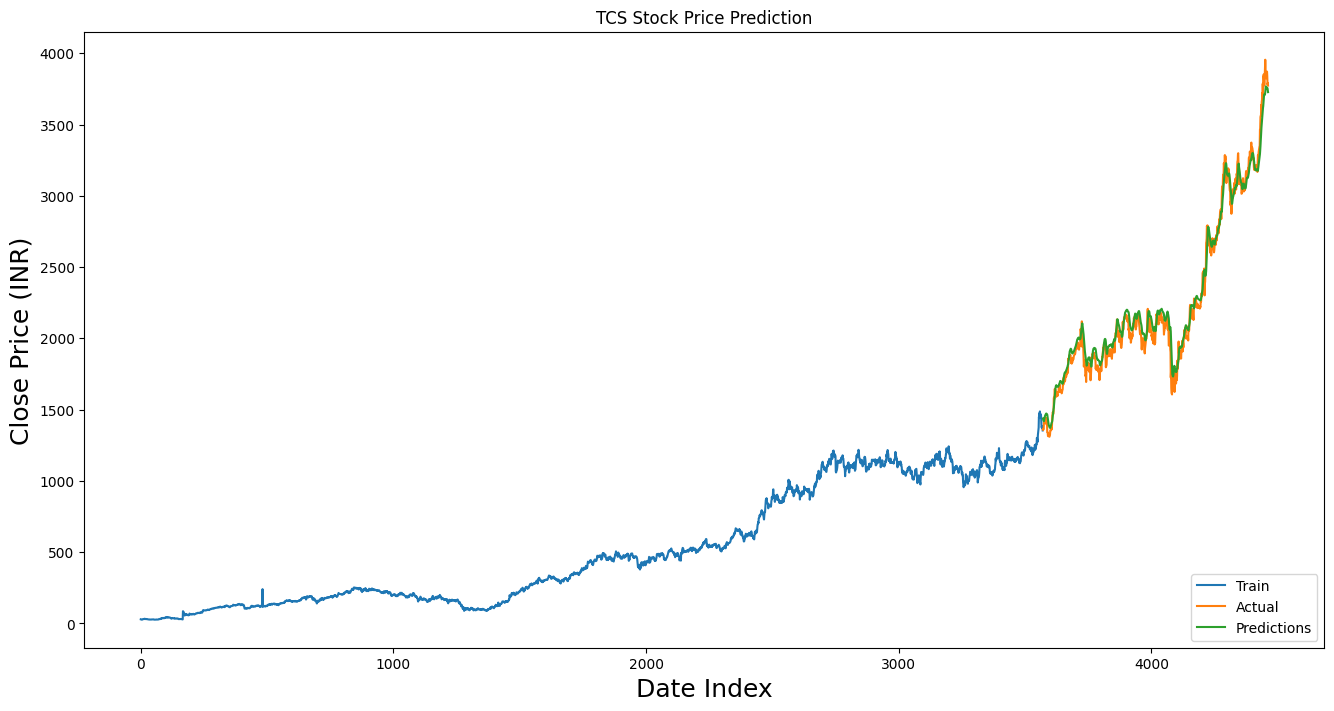

In [11]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:].copy() # Use .copy() to avoid SettingWithCopyWarning
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('TCS Stock Price Prediction')
plt.xlabel('Date Index', fontsize=18)
plt.ylabel('Close Price (INR)', fontsize=18)
plt.plot(train['Close'], label='Train')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [12]:
print("\n--- Validation Data with Predictions ---")
print(valid)


--- Validation Data with Predictions ---
            Close  Predictions
3571  1360.457153  1437.931030
3572  1363.805054  1429.945679
3573  1359.411255  1424.587524
3574  1369.245483  1420.580566
3575  1414.604004  1419.284058
...           ...          ...
4458  3871.300049  3755.266113
4459  3836.949951  3757.093262
4460  3779.149902  3753.780762
4461  3791.899902  3740.265625
4462  3773.199951  3727.292236

[892 rows x 2 columns]
